## Get Backend

In [1]:
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider()

backends_info = {
    'ibm_canberra' : "q-info-hackathon/team-21/main",
    'ibmq_mumbai' : "ibm-q-skku/hackathon-2023/hackathon",
    'ibm_hanoi' : 'ibm-q-skku/hackathon-2023/hackathon'
    }

backend_name, instance = list(backends_info.items())[0]

backend = provider.get_backend(backend_name, instance=instance)
print(f"Using {backend.name}")

Using ibm_canberra


## Make and Transpile Circuits

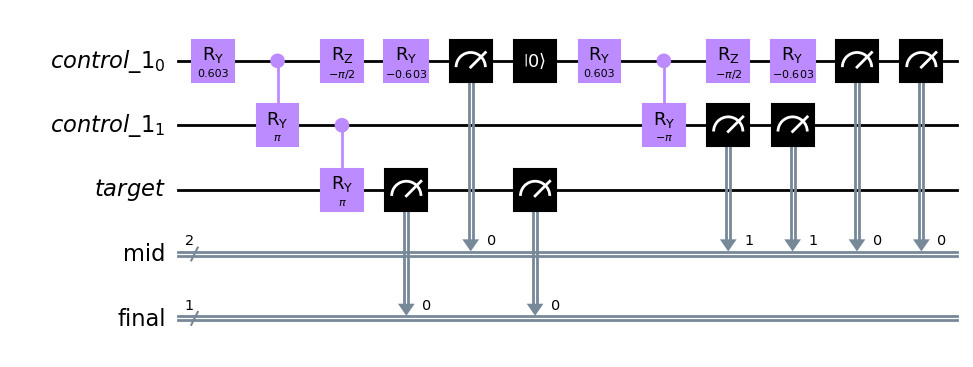

In [128]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def trial(circuit, target, control, theta, measure):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.ry(2*theta, control)
    circuit.cy(control, target)
    circuit.rz(-np.pi/2, control)
    circuit.ry(-2*theta, control)
    circuit.measure(control, measure)

def repeat_block(circuit, target, control, theta, measure):
    with circuit.if_test((measure, 0)) as else_:
        pass
    with else_:
        # Reset the control and target.
        circuit.x(control)
        circuit.ry(-np.pi/2, target)
        # Then repeat the trial.
        trial(circuit, target, control, theta, measure)

def RUS_circuit_1fold(theta, max_trials=2):
    control = QuantumRegister(1, name="control")
    target = QuantumRegister(1, name="target")
    mid_measure = ClassicalRegister(1, name="mid")
    final_measure = ClassicalRegister(1, name="final")
    circuit = QuantumCircuit(control, target, mid_measure, final_measure)

    # make circuit
    trial(circuit, target, control, theta, mid_measure)
    for _ in range(max_trials - 1): repeat_block(circuit, target, control, theta, mid_measure)
    circuit.measure(control, mid_measure)
    circuit.measure(target, final_measure)

    return circuit

def RUS_circuit_2fold(theta, max_trials=2):
    
    def trial(circuit, target, control, theta, measure, y_phase):
        # make circuit
        circuit.ry(2*theta, control)
        if y_phase == 'i':
            circuit.cry(-np.pi, control, target)
        elif y_phase == '-i':
            circuit.cry(np.pi, control, target)
        circuit.rz(-np.pi/2, control)
        circuit.ry(-2*theta, control)
        circuit.measure(control, measure)
    
    def trial_2(circuit, target, control, theta, mid_measure):
        trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')
        for _ in range(max_trials - 1):
            with circuit.if_test((mid_measure[0], 0)) as else_:
                pass
            with else_:
                # Reset the control and target.
                circuit.x(control[0])
                circuit.ry(-np.pi, control[1])
                # Then repeat the trial.
                trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')

        circuit.cry(np.pi, control[1], target)
        circuit.reset(control[0])
        
        trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')
        for _ in range(max_trials - 1):
            with circuit.if_test((mid_measure[0], 0)) as else_:
                pass
            with else_:
                # Reset the control and target.
                circuit.x(control[0])
                circuit.ry(-np.pi, control[1])
                # Then repeat the trial.
                trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')

    control = QuantumRegister(2, name="control_1")
    target = QuantumRegister(1, name="target")
    mid_measure = ClassicalRegister(2, name="mid")
    
    final_measure = ClassicalRegister(1, name="final")
    circuit = QuantumCircuit(control, target, mid_measure, final_measure)

    trial_2(circuit, target, control, theta, mid_measure)

    circuit.measure(control[1], mid_measure[1])
    circuit.measure(target, final_measure)

    for _ in range(max_trials - 1):
        with circuit.if_test((mid_measure[1], 0)) as else_:
            pass
        with else_:
            # Reset the control and target.
            circuit.x(control[1])
            circuit.ry(-np.pi, target)
            # Then repeat the trial.
            trial_2(circuit, target, control, theta, mid_measure)

    # trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')
    # for _ in range(max_trials - 1):
    #     with circuit.if_test((mid_measure[0], 0)) as else_:
    #         pass
    #     with else_:
    #         # Reset the control and target.
    #         circuit.x(control[0])
    #         circuit.ry(-np.pi, control[1])
    #         # Then repeat the trial.
    #         trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')

    # circuit.cry(np.pi, control[1], target)
    # circuit.reset(control[0])
    
    # trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='i')
    # for _ in range(max_trials - 1):
    #     with circuit.if_test((mid_measure[0], 0)) as else_:
    #         pass
    #     with else_:
    #         # Reset the control and target.
    #         circuit.x(control[0])
    #         circuit.ry(-np.pi, control[1])
    #         # Then repeat the trial.
    #         trial(circuit, control[1], control[0], theta, mid_measure[0], y_phase='-i')

    circuit.measure(control, mid_measure)
    circuit.measure(target, final_measure)

    return circuit

thetas = np.linspace(0, np.pi/2, 100)
circuits_1fold = []
circuits_2fold = []

for i, theta in enumerate(thetas):
    circuits_1fold.append(RUS_circuit_1fold(theta, max_trials=4))
    circuits_2fold.append(RUS_circuit_2fold(theta, max_trials=2))

# transpile
builts_1fold = [transpile(circuits_1fold[i], backend) for i in range(len(circuits_1fold))]
builts_2fold = [transpile(circuits_2fold[i], backend) for i in range(len(circuits_2fold))]

circuits_2fold[19].draw('mpl')

## Get Result (1fold)

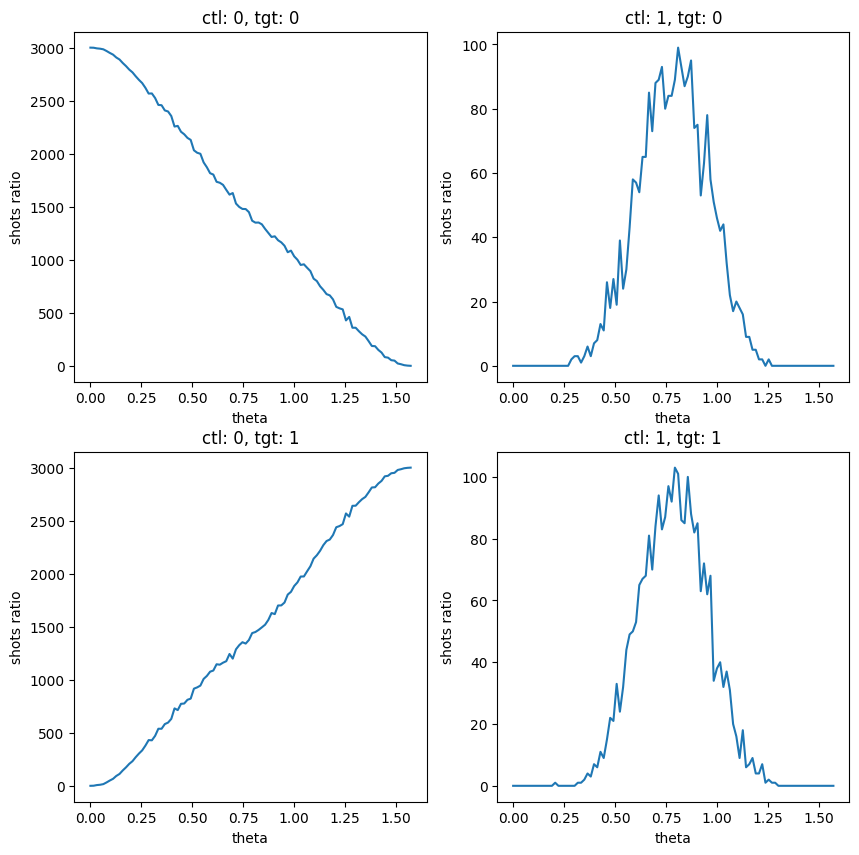

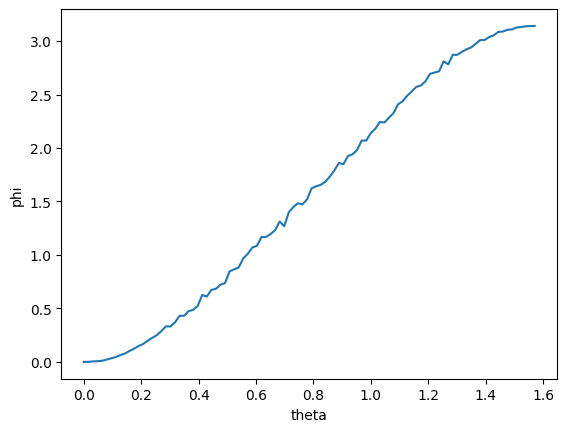

In [117]:
import numpy as np

# simulate
sim = AerSimulator(method="statevector")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plot_data = [{'x':thetas, 'y':[]} for _ in range(4)]

num_shots = 3000

for built in builts_1fold:

    simulator_result = sim.run(built, shots=num_shots).result()
    simulator_counts = simulator_result.get_counts()
    # print(simulator_counts)
    keys = ['0 0', '0 1', '1 0', '1 1']
    for k in keys :
        if k not in simulator_counts.keys():
            simulator_counts[k] = 0
    
    for k, v in simulator_counts.items():
        for k_ in keys:
            if k == k_:
                plot_data[keys.index(k_)]['y'].append(v)

for i, data in enumerate(plot_data):
    axs[i//2, i%2].plot(data['x'], data['y'])
    axs[i//2, i%2].title.set_text(f'ctl: {keys[i][2:]}, tgt: {keys[i][0]}')
    axs[i//2, i%2].set(xlabel="theta", ylabel="shots ratio")

plt.show()
plt.close()

final_0 = plot_data[0]['y']
final_1 = plot_data[2]['y']
phi_list = []
for i in range(len(final_0)):
    phi_list.append(2*np.arctan(final_1[i]/final_0[i]) if final_0[i] != 0 else np.pi)
    
plt.figure()
plt.plot(data['x'], phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()

## Get Result (2fold)

{'0 00': 3000}
{'1 10': 1, '0 01': 2, '0 00': 2997}
{'1 10': 5, '0 11': 3, '0 01': 4, '0 00': 2988}
{'1 10': 4, '0 11': 16, '0 01': 13, '0 00': 2967}
{'0 11': 15, '0 01': 9, '1 10': 16, '0 00': 2960}
{'0 01': 15, '1 10': 14, '0 11': 28, '0 00': 2943}
{'0 11': 27, '1 10': 26, '0 01': 35, '0 00': 2912}
{'1 10': 35, '1 11': 1, '0 11': 27, '0 01': 41, '0 00': 2896}
{'1 01': 1, '1 10': 40, '1 11': 1, '0 11': 46, '0 01': 46, '0 10': 1, '0 00': 2865}
{'1 11': 1, '0 11': 60, '0 01': 76, '1 10': 57, '0 10': 1, '0 00': 2805}
{'1 10': 69, '1 11': 3, '0 11': 66, '0 01': 82, '0 10': 1, '0 00': 2779}
{'1 00': 1, '1 01': 2, '0 01': 86, '1 10': 73, '1 11': 5, '0 11': 88, '0 10': 2, '0 00': 2743}
{'1 11': 4, '0 11': 104, '1 01': 7, '0 01': 119, '1 10': 106, '0 10': 6, '0 00': 2654}
{'1 01': 7, '0 01': 105, '1 10': 125, '0 11': 103, '1 11': 6, '0 10': 11, '0 00': 2643}
{'1 01': 9, '1 11': 9, '0 11': 122, '1 10': 144, '0 01': 145, '0 10': 2, '0 00': 2569}
{'1 00': 1, '1 01': 7, '1 10': 165, '0 01': 154, 

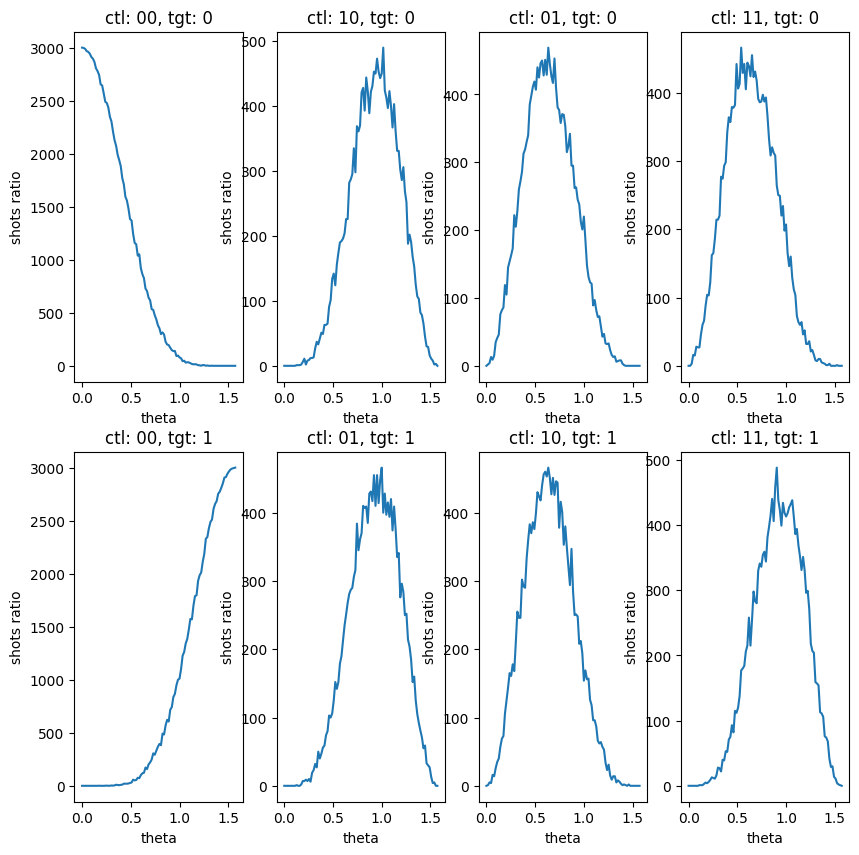

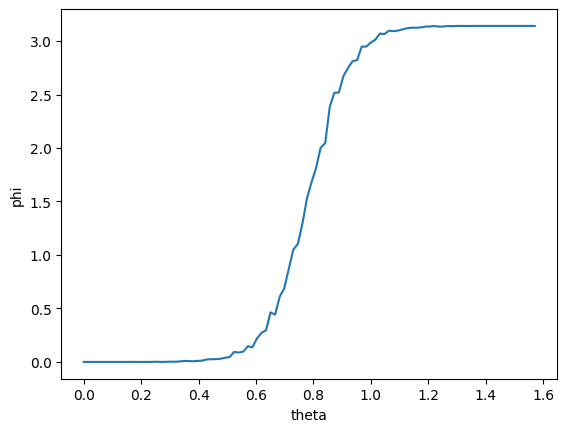

In [129]:
# simulate
sim = AerSimulator(method="statevector")

qubit_num = 3

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))

plot_data = [{'x':thetas, 'y':[]} for _ in range(2**3)]

num_shots = 3000

for built in builts_2fold:

    simulator_result = sim.run(built, shots=num_shots).result()
    simulator_counts = simulator_result.get_counts()
    print(simulator_counts)
    keys = ['0 00', '0 10', '0 01', '0 11', '1 00', '1 01', '1 10', '1 11']
    for k in keys :
        if k not in simulator_counts.keys():
            simulator_counts[k] = 0
    
    for k, v in simulator_counts.items():
        for k_ in keys:
            if k == k_:
                plot_data[keys.index(k_)]['y'].append(v)

for i, data in enumerate(plot_data):
    axs[i//4, i%4].plot(data['x'], data['y'])
    axs[i//4, i%4].title.set_text(f'ctl: {keys[i][2:]}, tgt: {keys[i][0]}')
    axs[i//4, i%4].set(xlabel="theta", ylabel="shots ratio")

plt.show()
plt.close()

final_0 = plot_data[0]['y']
final_1 = plot_data[4]['y']
phi_list = []
for i in range(len(final_0)):
    phi_list.append(2*np.arctan(final_1[i]/final_0[i]) if final_0[i] != 0 else np.pi)
    
plt.figure()
plt.plot(data['x'], phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()